<a href="https://colab.research.google.com/github/youcef-benmohammed/blood.group.detection/blob/main/blood_group_detection_using_image_processing_and_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Group Detection Using Image Processing and Deep learning

## Introduction



Paper :
[A Novel Approach to Predict Blood Group using Fingerprint Map Reading](https://www.researchgate.net/publication/351487579_A_Novel_Approach_to_Predict_Blood_Group_using_Fingerprint_Map_Reading)

## Load packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### Parmeters

## Load the read

There are 8 diffrent blood groups (clasees), as following:



*   **0: A+;**
*   **1: A-;**
*   **2: AB+;**
*   **3: AB-;**
*   **4: B+;**
*   **5: B-;**
*   **6: O+;**
*   **7: O-**.



In [ ]:
# Import the dataset from kaggle
# install Kaggle library
!pip install -q kaggle


In [ ]:
# Upload Kaggle json file!
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset > /dev/null 2>&1

In [ ]:
!unzip -q finger-print-based-blood-group-dataset.zip -d /content/dataset

replace /content/dataset/dataset_blood_group/A+/cluster_0_1001.BMP? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
import glob
file_path = '/content/dataset/dataset_blood_group/'
labels = os.listdir(file_path)
print(labels)

['A-', 'O-', 'B+', 'B-', 'AB+', 'O+', 'AB-', 'A+']


In [ ]:
filepaths = list(glob.glob(file_path + '**/*.BMP'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
fileapth = pd.Series(filepaths, name='filePath').astype(str)
labels = pd.Series(labels, name='label')
df = pd.concat([fileapth, labels], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

filePath label
0  /content/dataset/dataset_blood_group/AB-/clust...   AB-
1  /content/dataset/dataset_blood_group/O+/cluste...    O+
2  /content/dataset/dataset_blood_group/A-/cluste...    A-
3  /content/dataset/dataset_blood_group/A+/cluste...    A+
4  /content/dataset/dataset_blood_group/A-/cluste...    A-

In [ ]:

labels = {'A+': 0, 'A-': 1,'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7 }

# function to get class distribution
def get_class_distribution(df, verbose=True):
    labels_count = df['label'].value_counts()
    total_sample = len(df)

    for label, count in labels_count.items():
        percentage = round(count / total_sample * 100, 2)
        print("{:<20s}:   {} or {}%".format(label, count, percentage))

get_class_distribution(df)


A-                  :   1009 or 16.82%
O+                  :   852 or 14.2%
AB-                 :   761 or 12.68%
B-                  :   741 or 12.35%
O-                  :   712 or 11.87%
AB+                 :   708 or 11.8%
B+                  :   652 or 10.87%
A+                  :   565 or 9.42%


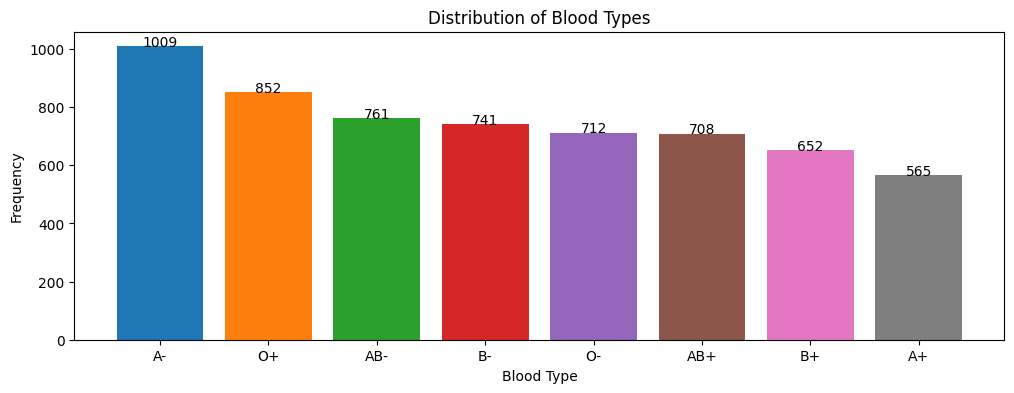

In [ ]:
def plot_label_per_class(data):
    blood_type_counts = data['label'].value_counts()
    plt.figure(figsize=(12, 4))
    colors = plt.cm.tab10(range(len(blood_type_counts)))
    plt.bar(blood_type_counts.index, blood_type_counts.values, color=colors)
    plt.xlabel('Blood Type')
    plt.ylabel('Frequency')
    plt.title('Distribution of Blood Types')
    for i, count in enumerate(blood_type_counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.show()

plot_label_per_class(df)

In [ ]:
df.head()

filePath label
0  /content/dataset/dataset_blood_group/AB-/clust...   AB-
1  /content/dataset/dataset_blood_group/O+/cluste...    O+
2  /content/dataset/dataset_blood_group/A-/cluste...    A-
3  /content/dataset/dataset_blood_group/A+/cluste...    A+
4  /content/dataset/dataset_blood_group/A-/cluste...    A-

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image  # Import PIL for image processing
# Image dimensions
IMG_ROWS = 128
IMG_COLS = 128
BATCH_SIZE = 32

def sample_images_data(data, labels):
    sample_images = []
    sample_labels = []

    # Itérer sur chaque label dans le dictionnaire
    for label in labels.keys():
        # Obtenir jusqu'à 4 échantillons correspondant à chaque label
        samples = data[data['label'] == label].head(4)

        for j in range(len(samples)):
            # Charger l'image à partir du chemin de fichier
            img_path = samples.iloc[j]['filePath']
            img = Image.open(img_path).convert("L") # Ouvrir l'image et la convertir en RGB

            # Redimensionner l'image aux dimensions souhaitées
            img = img.resize((IMG_COLS, IMG_ROWS))
            img_array = np.array(img)  # Convertir l'image en tableau numpy

            sample_images.append(img_array)
            sample_labels.append(samples.iloc[j]['label'])  # Utiliser la colonne label

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

sample_images, sample_labels = sample_images_data(df, labels)


Total number of sample images to plot:  32


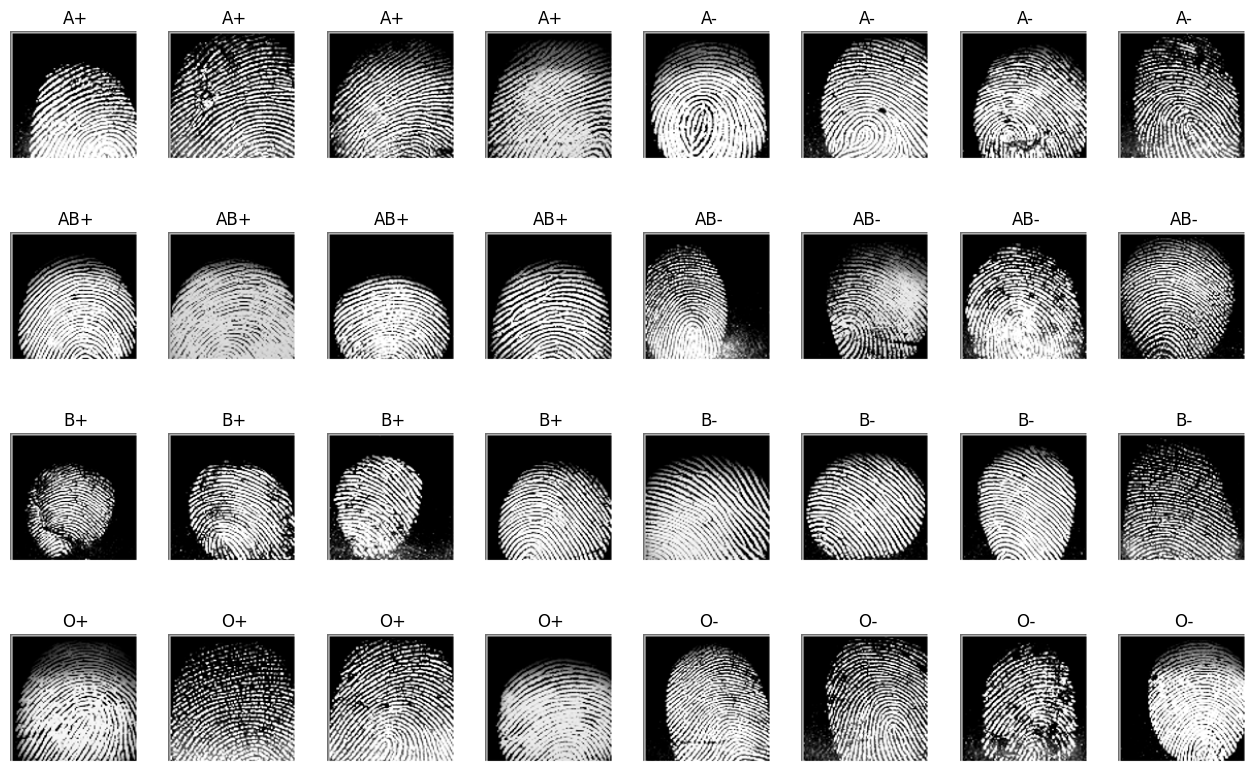

In [ ]:
def plot_images(images, labels, cmap="Blues"):
    f, ax = plt.subplots(4,8, figsize=(16,10))

    for i, img in enumerate(images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[i])
    plt.show()
plot_images(sample_images, sample_labels, cmap='Greys')


## Split data

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

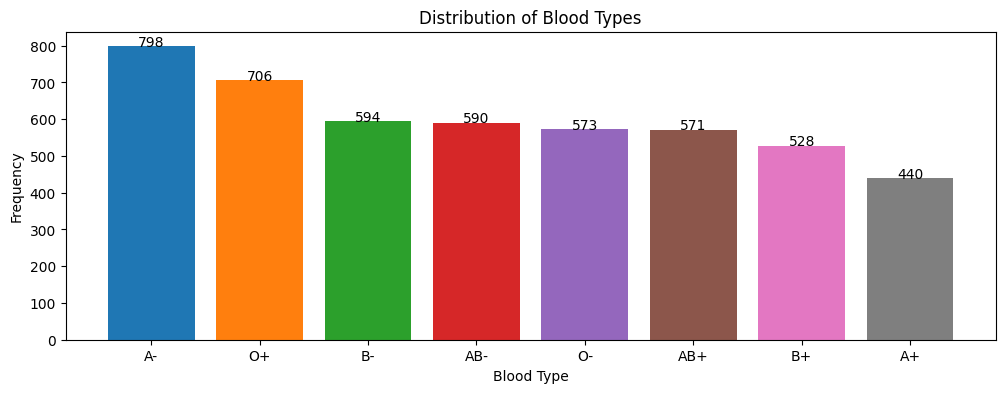

In [ ]:
plot_label_per_class(train_data)

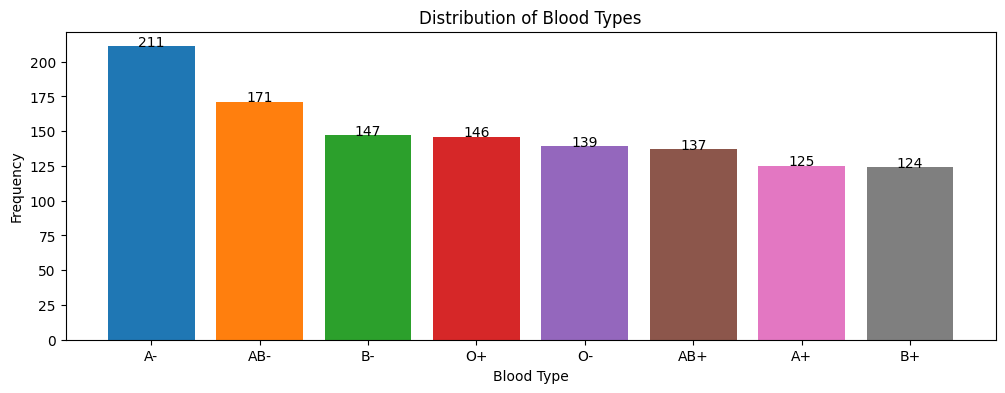

In [ ]:
plot_label_per_class(test_data)

Total number of sample images to plot:  32


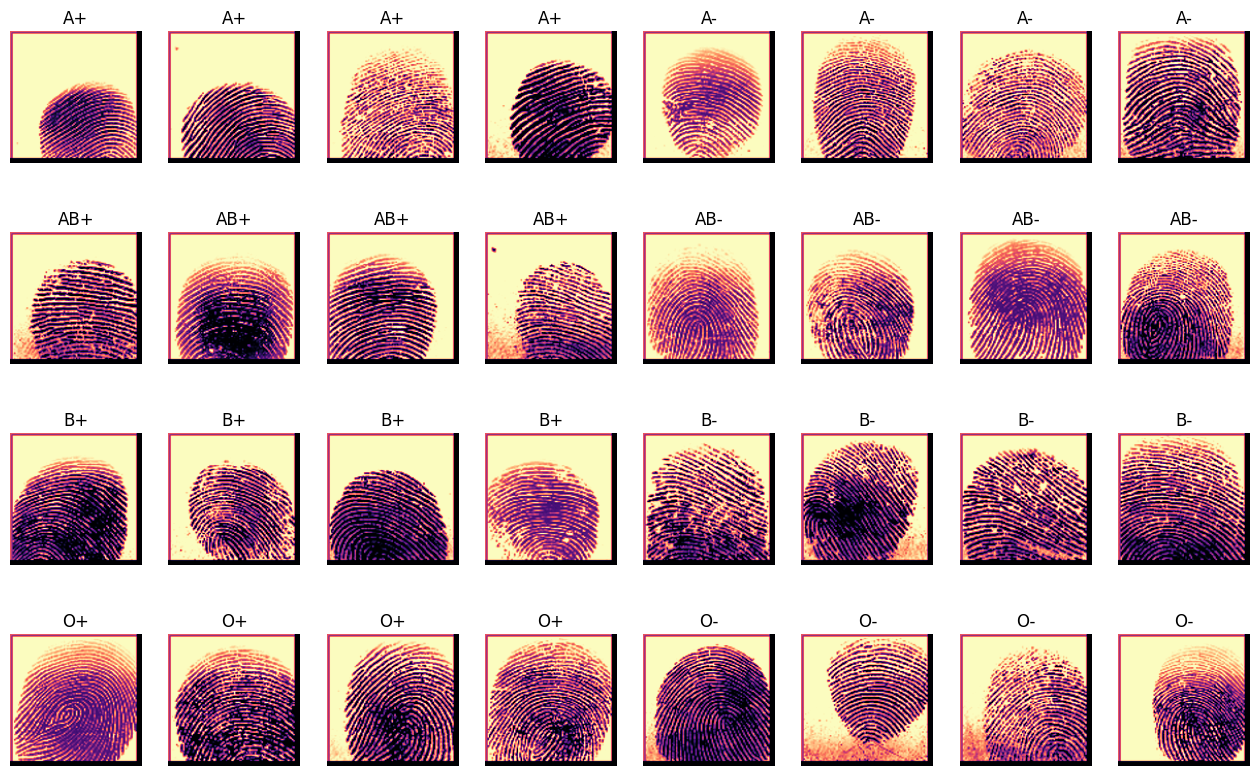

In [ ]:
sample_images, sample_labels = sample_images_data(train_data, labels)
plot_images(sample_images, sample_labels, cmap='magma')

Total number of sample images to plot:  32


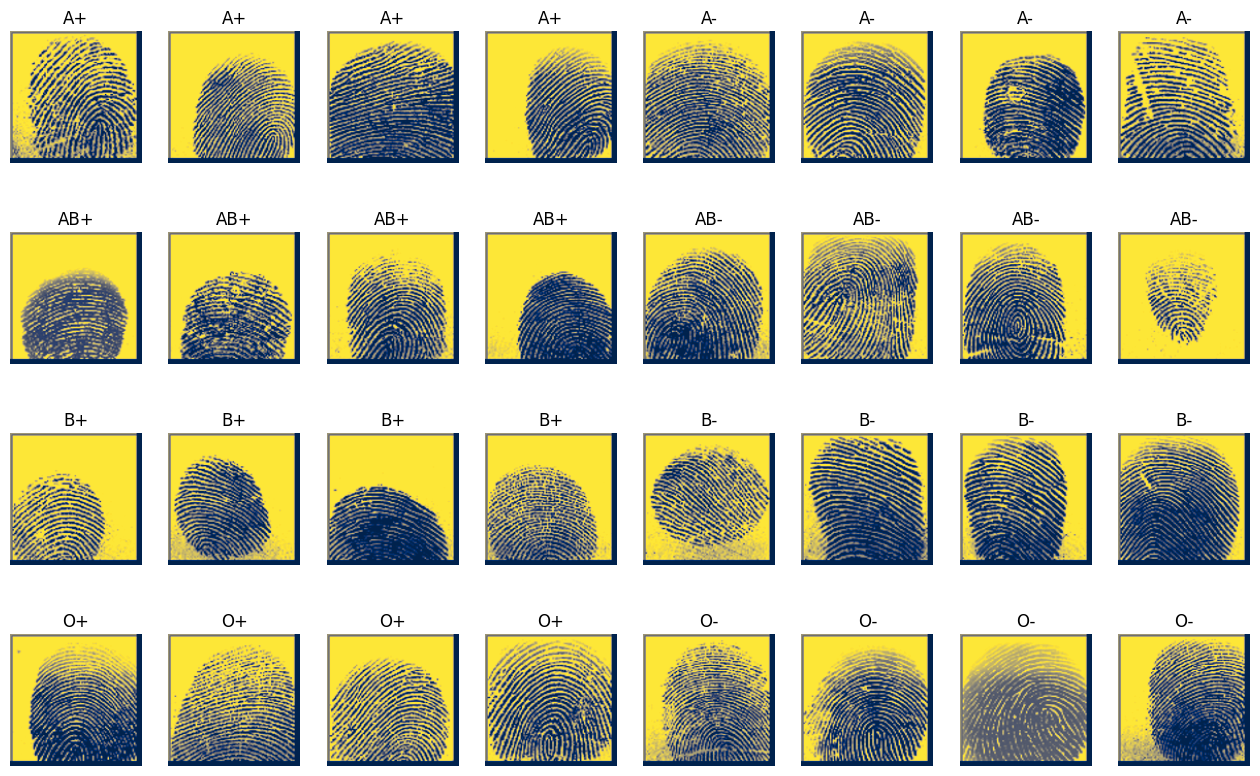

In [ ]:
sample_images, sample_labels = sample_images_data(test_data, labels)
plot_images(sample_images, sample_labels, cmap='cividis')

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    train_data,
    x_col='filePath',
    y_col='label',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 4800 validated image filenames belonging to 8 classes.


In [ ]:
test_gen = test_datagen.flow_from_dataframe(
    test_data,
    x_col='filePath',
    y_col='label',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 1200 validated image filenames belonging to 8 classes.


In [ ]:
valid_gen = train_datagen.flow_from_dataframe(
    test_data,
    x_col='filePath',
    y_col='label',
    target_size=(IMG_ROWS, IMG_COLS),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 1200 validated image filenames belonging to 8 classes.


In [ ]:
pretrained_model = ResNet50(
      include_top=False,
      input_shape=(IMG_ROWS, IMG_COLS, 3),
      weights='imagenet',
      pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks = [EarlyStopping(monitor="val_accuracy", patience=2,
                              min_delta=0, mode="auto")]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.3627 - loss: 1.6621 - val_accuracy: 0.6250 - val_loss: 0.9644
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.6554 - loss: 0.8941 - val_accuracy: 0.6933 - val_loss: 0.7969
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7257 - loss: 0.7084 - val_accuracy: 0.6792 - val_loss: 0.7968
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7732 - loss: 0.5668 - val_accuracy: 0.7433 - val_loss: 0.7120
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8348 - loss: 0.4413 - val_accuracy: 0.7633 - val_loss: 0.6296
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8316 - loss: 0.4360 - val_accuracy: 0.7683 - val_loss: 0.5958
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8650 - loss: 0.3679 - val_accuracy: 0.7275 - val_loss: 0.7487
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8519 - loss: 0.3832 - val_accuracy: 0.